In [136]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [275]:
data = pd.io.stata.read_stata("data_candidates_mainsample.dta")
data.to_csv('data_candidates_mainsample.csv')

data2 = pd.io.stata.read_stata("data_candidates_sample_tab6.dta")
data2.to_csv('data_\candidates_sample_tab6.csv')

data3 = pd.io.stata.read_stata("data_candidates_sample_tab7_tabA9.dta")
data3.to_csv('data_candidates_sample_tab7_tabA9.csv')

dataRe = pd.io.stata.read_stata("data_recruiters.dta")
dataRe.to_csv('data_recruiters.csv')

data_stata = pd.io.stata.StataReader("data_candidates_mainsample.dta")
data_labels = data_stata.variable_labels()

# Summary Bias


# DATA1


In [287]:
data = data.fillna(0)
#data[47:58]

<AxesSubplot:xlabel='eoq', ylabel='count'>

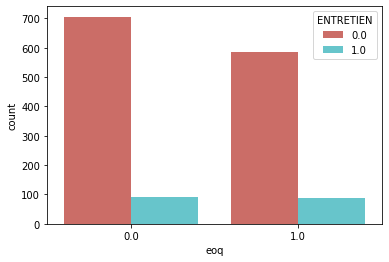

In [270]:
#skilled while/blue collar
sns.countplot(x='eoq', hue = 'ENTRETIEN', data=data, palette='hls')

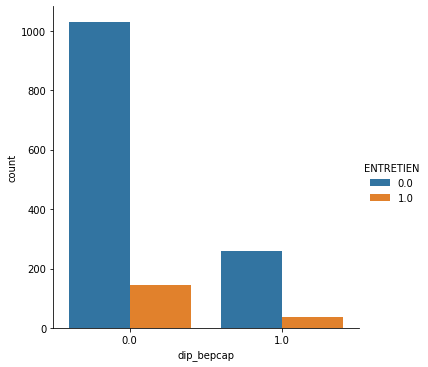

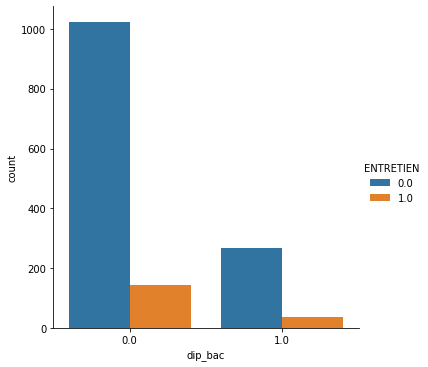

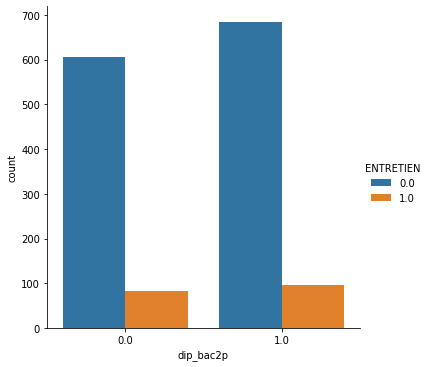

In [256]:
#professions
#data1['dip_bepcap'] professional
#data1['dip_bac'] high school
#data1['dip_bac2p'] upper education
#data1['dip_bac2']diploma 2 years after school
#data1['dip_bac3p'] diploma 3 years after school


sns.catplot(x = "dip_bepcap",hue = 'ENTRETIEN', kind = "count", data = data)
sns.catplot(x = "dip_bac", hue = 'ENTRETIEN', kind = "count", data = data)
sns.catplot(x = "dip_bac2p", hue = 'ENTRETIEN',kind = "count", data = data)

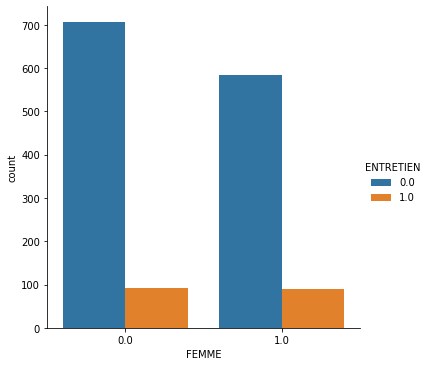

In [271]:
#gender
data['FEMME']
sns.catplot(x = "FEMME", hue = 'ENTRETIEN', kind = "count", data = data)

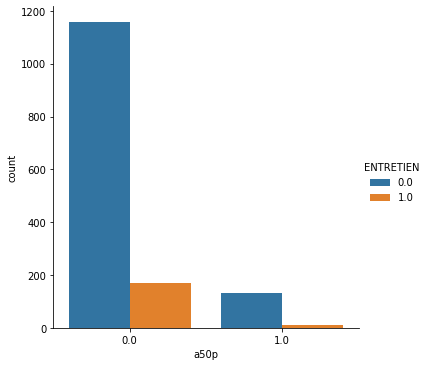

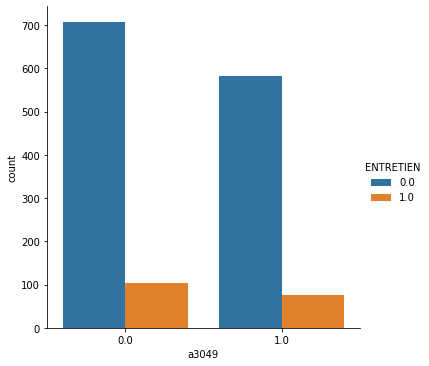

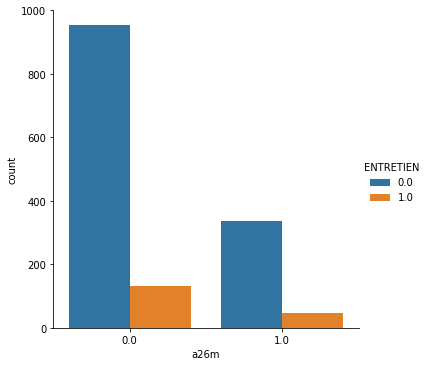

In [285]:
#age
data1['a50p']
data1['a3049']
data1['a26m']


sns.catplot(x = "a50p", hue = 'ENTRETIEN', kind = "count", data = data)
sns.catplot(x = "a3049", hue = 'ENTRETIEN', kind = "count", data = data)
sns.catplot(x = "a26m", hue = 'ENTRETIEN', kind = "count", data = data)


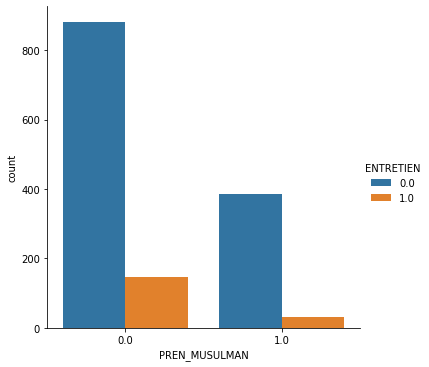

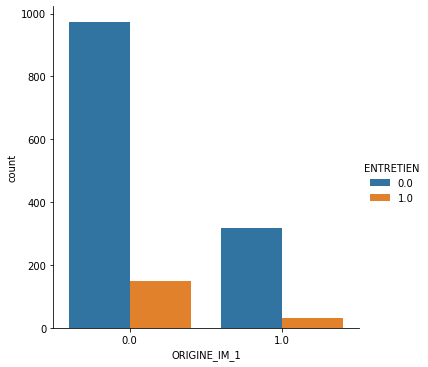

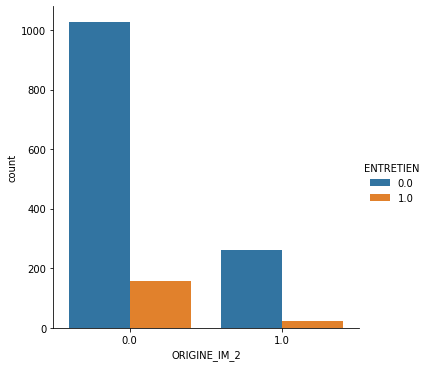

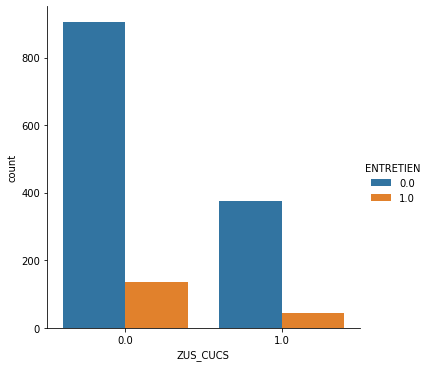

In [286]:
#race
data1['PREN_MUSULMAN'] #muslim sound name
data1['ORIGINE_IM_1'] #immigrant
data1['ORIGINE_IM_2']#immigrant child
data1['ORIGINE_IM_12'] #immigrant or immigrant child
data1['ZUS_CUCS'] #Depried neighbour

sns.catplot(x = "PREN_MUSULMAN", hue = 'ENTRETIEN', kind = "count", data = data)
sns.catplot(x = "ORIGINE_IM_1", hue = 'ENTRETIEN', kind = "count", data = data)
sns.catplot(x = "ORIGINE_IM_2", hue = 'ENTRETIEN', kind = "count", data = data)
sns.catplot(x = "ZUS_CUCS", hue = 'ENTRETIEN', kind = "count", data = data)


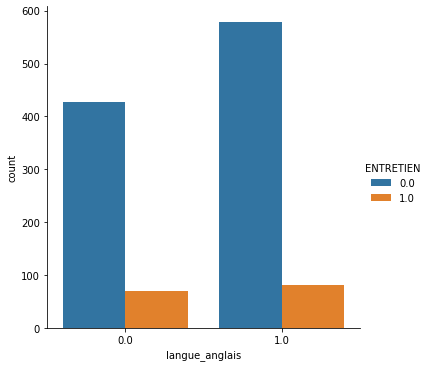

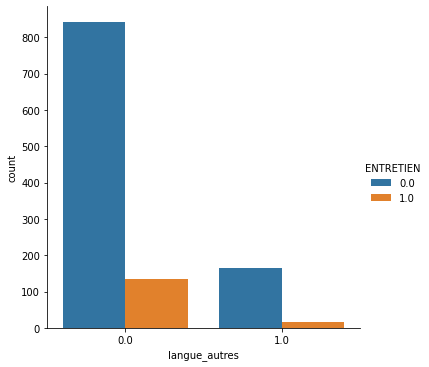

In [283]:
#language
data1['langue_anglais']
data1['langue_arabe']
data1['langue_autres']

sns.catplot(x = "langue_anglais", hue = 'ENTRETIEN', kind = "count", data = data)
sns.catplot(x = "langue_autres", hue = 'ENTRETIEN', kind = "count", data = data)